# PM 2.5 Concentration prediction in next hour with H2O at 556 Nguyen Van Cu station

In [1]:
import time

import h2o
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from h2o.estimators import H2OXGBoostEstimator, H2ODeepLearningEstimator, H2ORandomForestEstimator
from pandas import DataFrame
from sklearn import preprocessing

## Read data from the data.csv file

In [2]:
data = pd.read_csv("../data/data_2020_2022_tram_556NVC.csv")
data.dtypes

time               object
TEMP              float64
HUM               float64
PRESSURE          float64
RADIATION         float64
WIND_DIRECTION    float64
WIND_VELOCITY     float64
NO                float64
NO2               float64
NOX               float64
SO2               float64
O3                float64
CO                float64
PM10              float64
PM25              float64
PM01              float64
dtype: object

## Preview 10 samples

In [3]:
data.head(10)

time   TEMP    HUM  PRESSURE  RADIATION  WIND_DIRECTION  \
0  01/01/2020 00:05  23.62  89.93   1020.15       2.13           48.01   
1  01/01/2020 00:10  23.81  89.38   1020.15       4.18          267.18   
2  01/01/2020 00:15  23.91  88.99   1019.97       5.27           21.04   
3  01/01/2020 00:20  23.91  89.19   1019.95       1.48           31.01   
4  01/01/2020 00:25  23.93  88.90   1020.09       0.84           63.41   
5  01/01/2020 00:30  24.27  88.10   1019.69       1.05          321.56   
6  01/01/2020 00:35  24.20  87.60   1019.92       6.45          259.76   
7  01/01/2020 00:40  24.17  88.12   1019.73       5.48           20.02   
8  01/01/2020 00:45  23.96  88.81   1020.01       5.91          327.97   
9  01/01/2020 00:50  23.76  90.29   1019.92       1.27          115.33   

   WIND_VELOCITY      NO    NO2     NOX   SO2     O3       CO    PM10    PM25  \
0           1.13   81.47  49.71  131.18  8.58  11.79  5086.80  155.00  103.30   
1           0.62  135.34  63.88  199.22  9.44   9.64  5300.32  106.10   85.75   
2           0.57   61.91  58.95  120.86  8.58  11.79  4207.60  118.30   84.60   
3           0.71  126.76  55.87  182.63  8.87  12.86  5815.28  134.60   89.75   
4           0.44   92.19  58.13  150.32  8.87  11.36  5099.36  133.00   88.65   
5           0.60   86.97  53.61  140.58  8.58   9.21  4697.44  129.20   86.15   
6           0.91  121.81  56.90  178.70  9.15  14.79  6154.40  119.00   85.95   
7           0.41   77.85  56.07  133.93  8.29  11.79  4710.00  121.10   88.20   
8           0.75   91.79  54.64  146.43  8.87  11.36  5287.76   92.65   80.60   
9           0.77   79.33  56.07  135.40  8.87   8.79  4609.52  128.20   85.40   

    PM01  
0  79.25  
1  76.10  
2  76.05  
3  75.20  
4  74.00  
5  73.15  
6  75.50  
7  75.50  
8  75.60  
9  76.90

## Remove NaN and outliers

In [4]:
date_time = pd.to_datetime(data['time'], format="%d/%m/%Y %H:%M")
data['time'] = date_time
data = data.dropna(axis=0)
data = data.drop(['PRESSURE', 'WIND_DIRECTION', 'WIND_VELOCITY', 'NO', 'NO2', 'NOX', 'SO2', 'O3', 'PM10', 'PM01'],
                 axis=1)
data.describe()

time           TEMP            HUM  \
count                         261754  261754.000000  261754.000000   
mean   2021-07-21 11:46:07.190720768      26.546161      75.122298   
min              2020-01-01 00:05:00       9.800000      20.470000   
25%              2020-11-04 14:36:15      22.710000      65.070000   
50%              2021-07-31 06:37:30      27.020000      78.140000   
75%              2022-04-07 11:33:45      30.230000      87.310000   
max              2022-12-31 23:55:00      42.850000      99.990000   
std                              NaN       5.436343      15.375635   

           RADIATION             CO           PM25  
count  261754.000000  261754.000000  261754.000000  
mean      183.961609    1659.529365      26.151301  
min         0.000000       3.770000       0.000000  
25%         4.550000     801.500000      11.550000  
50%        21.090000    1293.850000      19.225000  
75%       252.640000    2164.050000      32.400000  
max      1876.970000   19018.450000     640.800000  
std       293.507683    1268.413636      22.829650

## Show factor histograms

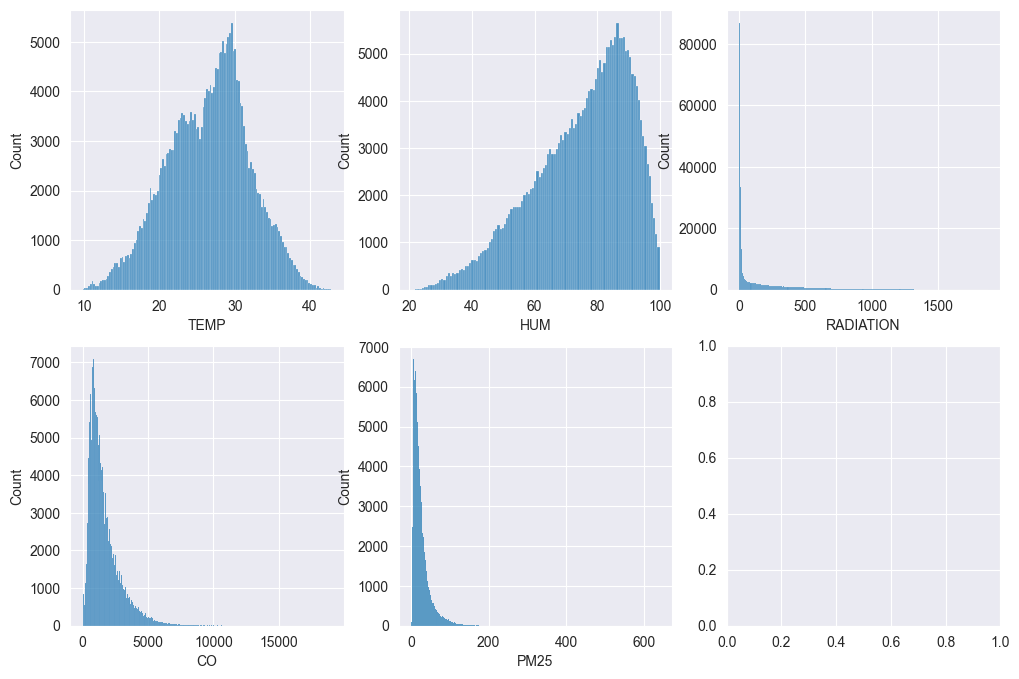

In [5]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))
sns.histplot(data["TEMP"], ax=axs[0, 0])
sns.histplot(data["HUM"], ax=axs[0, 1])
sns.histplot(data["RADIATION"], ax=axs[0, 2])
sns.histplot(data["CO"], ax=axs[1, 0])
sns.histplot(data["PM25"], ax=axs[1, 1])
plt.show()

## Show factor time-series plots

<Axes: xlabel='time'>

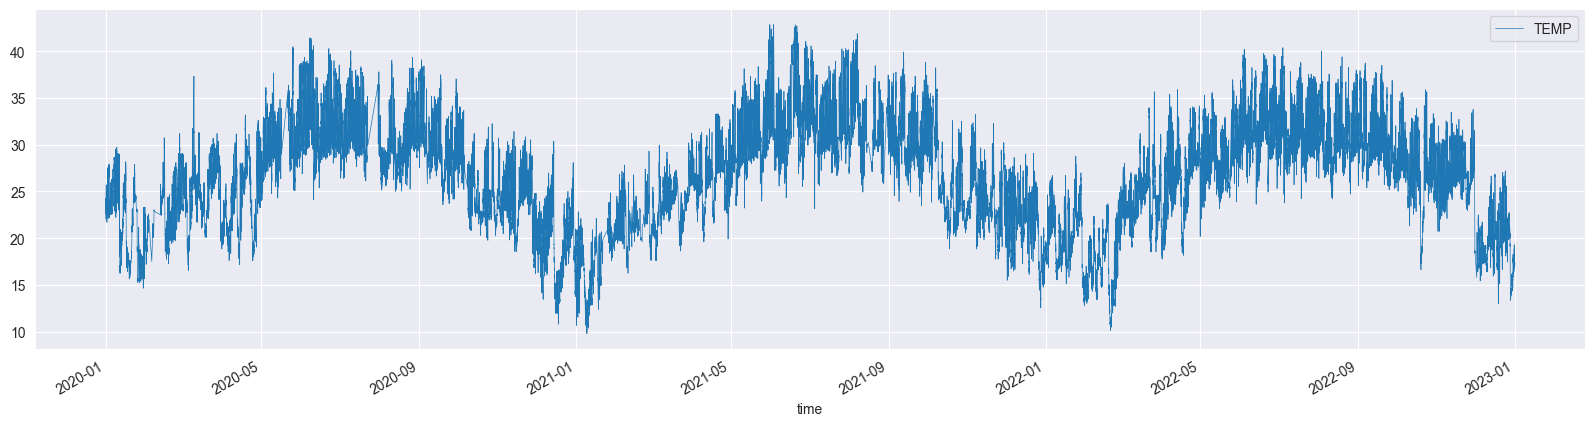

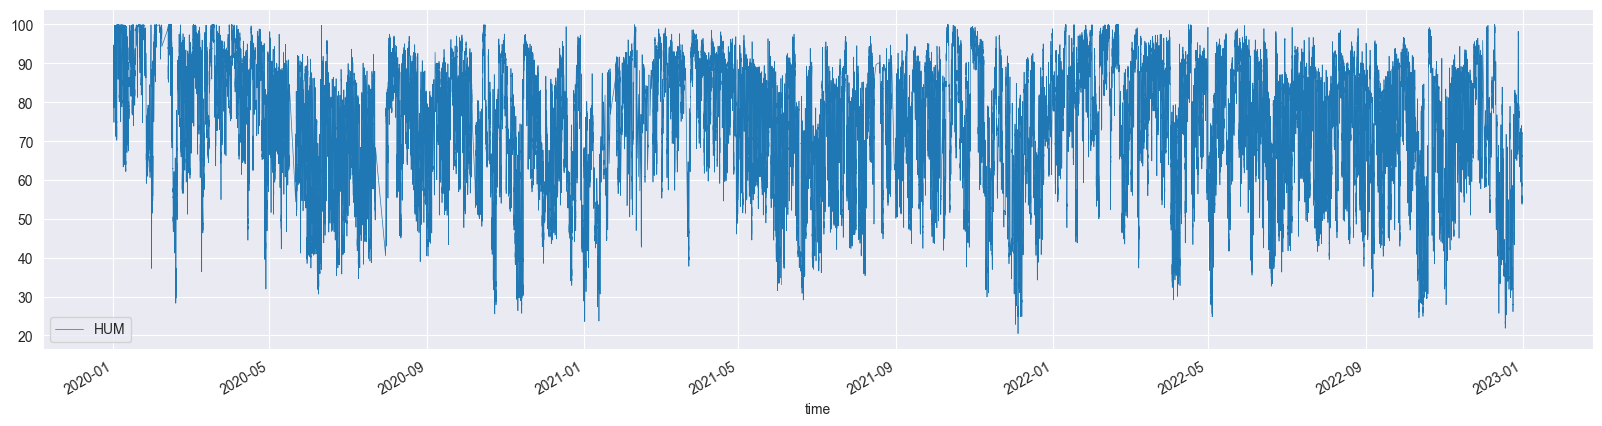

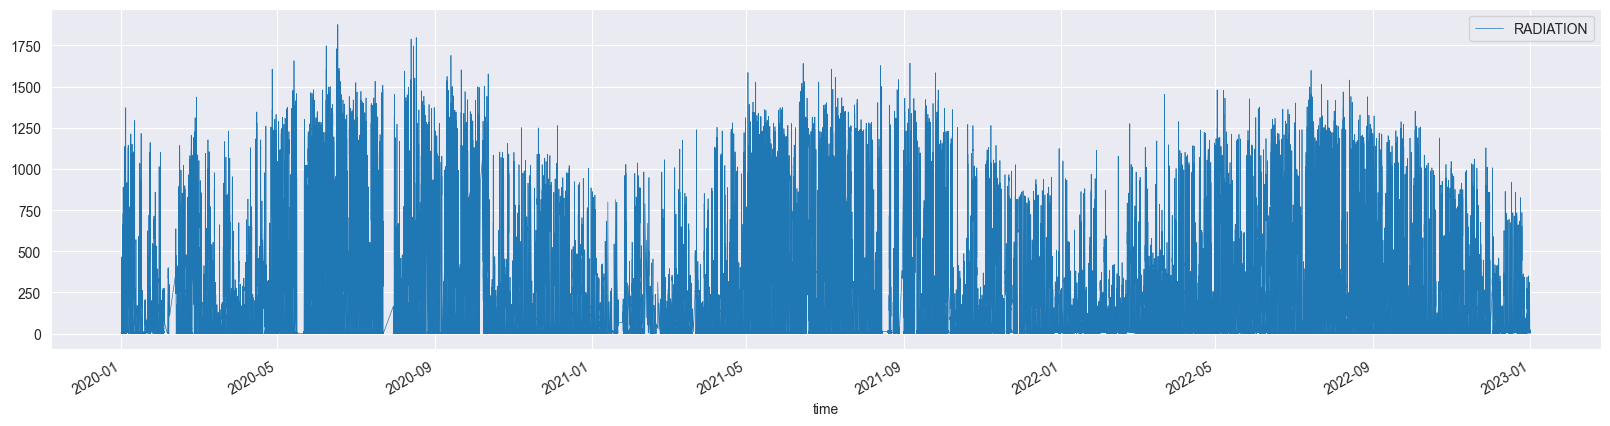

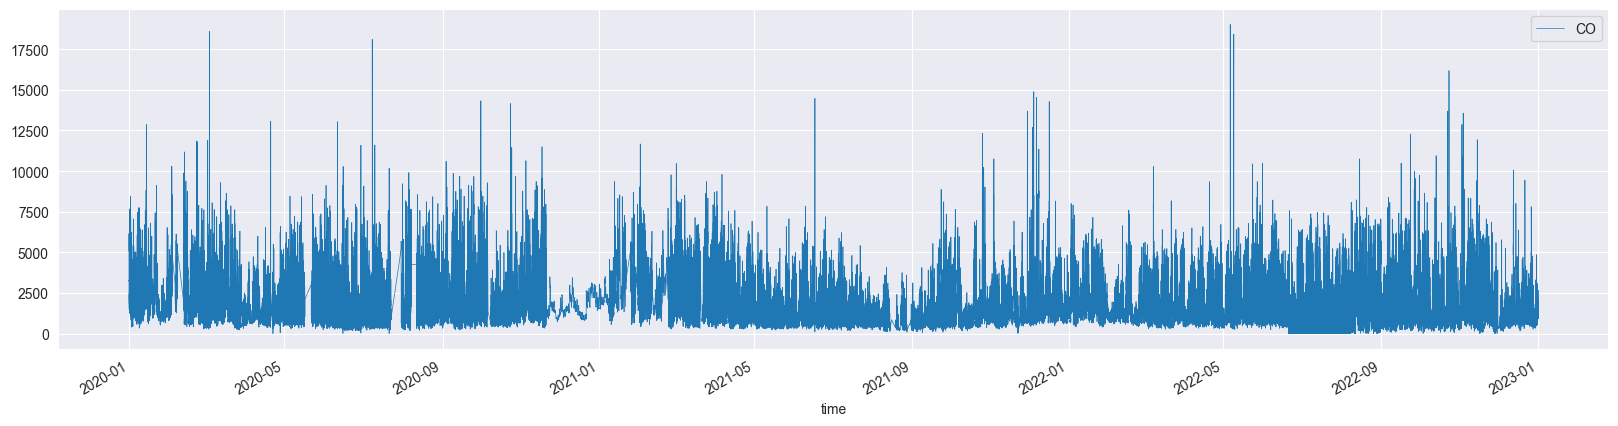

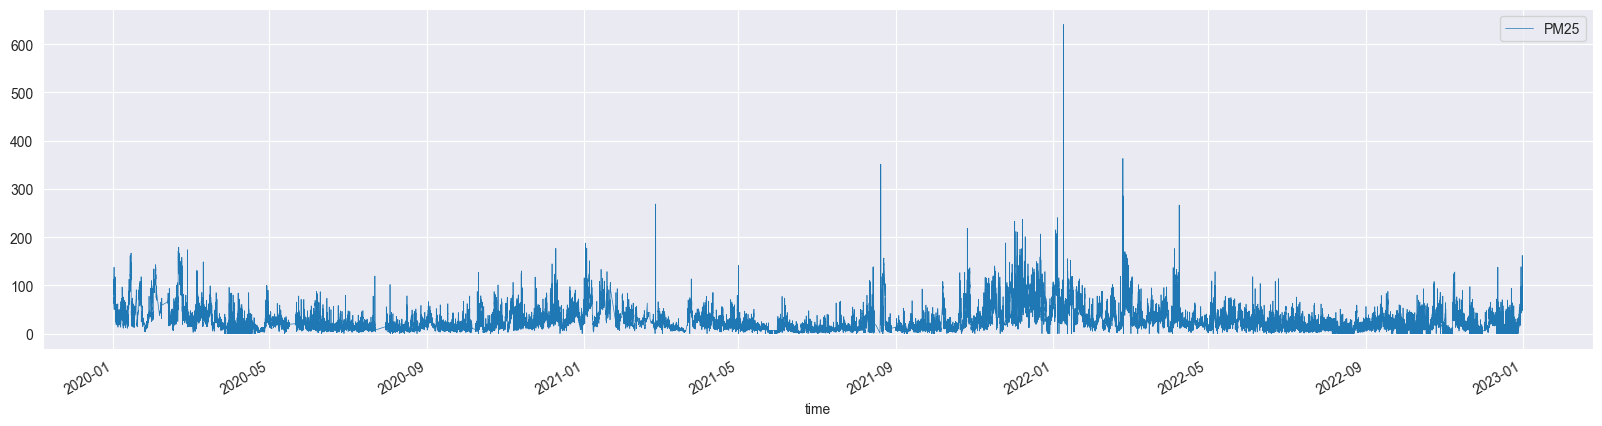

In [6]:
data.plot(x='time', y='TEMP', linewidth=0.5, figsize=(20, 5))
data.plot(x='time', y='HUM', linewidth=0.5, figsize=(20, 5))
data.plot(x='time', y='RADIATION', linewidth=0.5, figsize=(20, 5))
data.plot(x='time', y='CO', linewidth=0.5, figsize=(20, 5))
data.plot(x='time', y='PM25', linewidth=0.5, figsize=(20, 5))


## Generate features and labels
- List of all features:
    - **f0 - f1**: Season bins
    - **f2**: Month
    - **f3**: Weekend
    - **f4**: Hour
    - **f5**: Current PM25 AQI value
    - **f6**: Current CO concentration
    - **f7**: Current temperature
    - **f8**: Current humidity
    - **f9**: Current radiation
    - **f10 → f34**: PM25 AQI value from 1 to 24 hour ago
    - **f35**: maximum PM25 AQI value in last 24 hours
    - **f36**: minimum PM25 AQI value in last 24 hours
    - **f37**: average PM25 AQI value in last 24 hours
    - **f38**: maximum temperature in last 24 hours
    - **f39**: minimum temperature in last 24 hours
    - **f40**: average temperature in last 24 hours
    - **f41**: maximum humidity in last 24 hours
    - **f42**: minimum humidity in last 24 hours
    - **f43**: average humidity in last 24 hours
- Label: Next PM25 AQI value


### Create <i>Month</i>, <i>Day of week</i>, <i>Hour</i> features from time column.

In [7]:
time_idx = pd.DatetimeIndex(data.time)
data = data.groupby([time_idx.month, time_idx.day, time_idx.dayofweek, time_idx.hour]).mean(numeric_only=True)
data.index.names = ["Month", "Day", "Weekend", "Hour"]
data.index = data.index.droplevel(1)
data.head(20)

TEMP        HUM   RADIATION           CO        PM25
Month Weekend Hour                                                           
1     2       0     23.932727  89.098182    3.388182  5025.141818   88.150000
              1     23.140000  93.330000    3.940000  3249.614545   93.104545
              2     23.164000  91.873000    3.311000  2415.288000   99.510000
              3     23.561000  88.016000    3.979000  1921.680000  100.795000
              4     23.215556  87.672222    4.460000  1844.924444  100.144444
              5     22.682857  90.262857    5.261429  1988.068571  102.285714
              6     22.343000  91.078000    7.349000  2074.912000  100.595000
              7     22.398000  89.548000   36.571000  2583.592000   94.101000
              8     23.266667  85.401111  131.743333  3329.795556   93.538889
              9     24.206000  82.099000  207.160000  3300.768000   98.685000
              10    24.713333  78.965833  167.013333  3467.606667   84.854167
              11    24.227000  86.829000  298.385000  3756.696000   80.980000
              12    24.879000  83.279000  324.684000  3089.760000   91.450000
              13    24.770000  81.350000  310.576364  3360.370909   65.227273
              14    24.440909  83.457273  290.609091  3147.992727   61.945455
              15    24.282500  85.227500  184.435833  3653.913333   69.533333
              16    24.139091  84.536364   63.430909  3986.087273   62.977273
              17    23.879091  86.004545    8.001818  3161.694545   66.381818
              18    23.279000  90.066000    4.811000  2583.592000   79.670000
              19    23.661818  90.179091    5.950000  3054.363636   97.359091

### Generate f10 → f34 features

In [8]:
PM25_cols = []
TEMP_cols = []
HUM_cols = []

for i in range(1, 25):
    col = 'PM25P' + str(i)
    PM25_cols.append(col)
    data[col] = data['PM25'].shift(periods=i)

    col = 'TEMPP' + str(i)
    TEMP_cols.append(col)
    data[col] = data['TEMP'].shift(periods=i)

    col = 'HUMP' + str(i)
    HUM_cols.append(col)
    data[col] = data['HUM'].shift(periods=i)

data["MAXPM25"] = data[PM25_cols].max(axis=1)
data["MINPM25"] = data[PM25_cols].min(axis=1)
data["AVGPM25"] = data[PM25_cols].mean(axis=1)

data["MAXTEMP"] = data[TEMP_cols].max(axis=1)
data["MINTEMP"] = data[TEMP_cols].min(axis=1)
data["AVGTEMP"] = data[TEMP_cols].mean(axis=1)

data["MAXHUM"] = data[HUM_cols].max(axis=1)
data["MINHUM"] = data[HUM_cols].min(axis=1)
data["AVGHUM"] = data[HUM_cols].mean(axis=1)

data = data.drop(TEMP_cols, axis=1)
data = data.drop(HUM_cols, axis=1)

### Generate labels

In [9]:
data['Label'] = data['PM25'].shift(periods=-1)
data.head(25)

TEMP        HUM   RADIATION           CO        PM25  \
Month Weekend Hour                                                              
1     2       0     23.932727  89.098182    3.388182  5025.141818   88.150000   
              1     23.140000  93.330000    3.940000  3249.614545   93.104545   
              2     23.164000  91.873000    3.311000  2415.288000   99.510000   
              3     23.561000  88.016000    3.979000  1921.680000  100.795000   
              4     23.215556  87.672222    4.460000  1844.924444  100.144444   
              5     22.682857  90.262857    5.261429  1988.068571  102.285714   
              6     22.343000  91.078000    7.349000  2074.912000  100.595000   
              7     22.398000  89.548000   36.571000  2583.592000   94.101000   
              8     23.266667  85.401111  131.743333  3329.795556   93.538889   
              9     24.206000  82.099000  207.160000  3300.768000   98.685000   
              10    24.713333  78.965833  167.013333  3467.606667   84.854167   
              11    24.227000  86.829000  298.385000  3756.696000   80.980000   
              12    24.879000  83.279000  324.684000  3089.760000   91.450000   
              13    24.770000  81.350000  310.576364  3360.370909   65.227273   
              14    24.440909  83.457273  290.609091  3147.992727   61.945455   
              15    24.282500  85.227500  184.435833  3653.913333   69.533333   
              16    24.139091  84.536364   63.430909  3986.087273   62.977273   
              17    23.879091  86.004545    8.001818  3161.694545   66.381818   
              18    23.279000  90.066000    4.811000  2583.592000   79.670000   
              19    23.661818  90.179091    5.950000  3054.363636   97.359091   
              20    23.460000  92.842000    5.198000  2917.688000  105.820000   
              21    22.892727  95.267273    5.528182  3195.949091  109.345455   
              22    22.065556  98.265556    4.060000  2594.337778  107.088889   
              23    21.983750  97.353750    4.645000  1744.270000   96.712500   
      4       0     14.166667  65.856667    2.579167  2913.920000   49.741667   

                        PM25P1      PM25P2      PM25P3      PM25P4  \
Month Weekend Hour                                                   
1     2       0            NaN         NaN         NaN         NaN   
              1      88.150000         NaN         NaN         NaN   
              2      93.104545   88.150000         NaN         NaN   
              3      99.510000   93.104545   88.150000         NaN   
              4     100.795000   99.510000   93.104545   88.150000   
              5     100.144444  100.795000   99.510000   93.104545   
              6     102.285714  100.144444  100.795000   99.510000   
              7     100.595000  102.285714  100.144444  100.795000   
              8      94.101000  100.595000  102.285714  100.144444   
              9      93.538889   94.101000  100.595000  102.285714   
              10     98.685000   93.538889   94.101000  100.595000   
              11     84.854167   98.685000   93.538889   94.101000   
              12     80.980000   84.854167   98.685000   93.538889   
              13     91.450000   80.980000   84.854167   98.685000   
              14     65.227273   91.450000   80.980000   84.854167   
              15     61.945455   65.227273   91.450000   80.980000   
              16     69.533333   61.945455   65.227273   91.450000   
              17     62.977273   69.533333   61.945455   65.227273   
              18     66.381818   62.977273   69.533333   61.945455   
              19     79.670000   66.381818   62.977273   69.533333   
              20     97.359091   79.670000   66.381818   62.977273   
              21    105.820000   97.359091   79.670000   66.381818   
              22    109.345455  105.820000   97.359091   79.670000   
              23    107.088889  109.345455  105.820000   97.359091   
      4       0  

### Remove rows containing NaN values and add season feature columns

In [10]:
data = data.dropna()
columns = data.index.names
columns = np.append(columns, data.columns.values[:-1])
date_time_values = np.asmatrix([list(item) for item in data.index.values])
data = np.append(date_time_values, data.to_numpy(), axis=1)
data[:, 1] = np.where(data[:, 1] < 5, 0, 1)

bin_season = np.where(data[:, 0] <= 3, [0, 0], np.where(data[:, 0] <= 6, [0, 1], np.where(data[:, 0] <= 9, [1, 0],
                                                                                          np.where(data[:, 0] <= 12,
                                                                                                   [1, 1], 0))))
# data = np.delete(data, 0, 1)
data = np.append(bin_season, data, axis=1)
columns = ["SS_BIN_1", "SS_BIN_2"] + columns.tolist() + ["Label"]
processed_data = DataFrame(np.asarray(data), columns=columns)
processed_data.head(10)


SS_BIN_1  SS_BIN_2  Month  Weekend  Hour       TEMP        HUM   RADIATION  \
0       0.0       0.0    1.0      0.0   0.0  14.166667  65.856667    2.579167   
1       0.0       0.0    1.0      0.0   1.0  13.983333  66.140833    5.965833   
2       0.0       0.0    1.0      0.0   2.0  13.349167  67.267500    5.725833   
3       0.0       0.0    1.0      0.0   3.0  12.571667  63.394167    7.155833   
4       0.0       0.0    1.0      0.0   4.0  11.591667  65.200000    2.895833   
5       0.0       0.0    1.0      0.0   5.0  11.138182  65.359091    4.650000   
6       0.0       0.0    1.0      0.0   6.0  10.910833  64.503333   15.772500   
7       0.0       0.0    1.0      0.0   7.0  11.809167  60.382500  157.447500   
8       0.0       0.0    1.0      0.0   8.0  13.565833  46.513333  374.737500   
9       0.0       0.0    1.0      0.0   9.0  15.105833  36.480000  580.274167   

            CO       PM25  ...     MAXPM25    MINPM25    AVGPM25  MAXTEMP  \
0  2913.920000  49.741667  ...  109.345455  61.945455  89.593952   24.879   
1  2905.546667  61.150000  ...  109.345455  49.741667  87.993605   24.879   
2  2900.313333  67.585833  ...  109.345455  49.741667  86.662165   24.879   
3  2759.013333  89.367500  ...  109.345455  49.741667  85.331992   24.879   
4  2589.453333  56.350833  ...  109.345455  49.741667  84.855846   24.879   
5  2428.647273  44.604545  ...  109.345455  49.741667  83.031112   24.879   
6  2266.033333  60.662500  ...  109.345455  44.604545  80.627730   24.879   
7  2167.646667  49.538333  ...  109.345455  44.604545  78.963876   24.879   
8  2079.726667  35.942500  ...  109.345455  44.604545  77.107098   24.879   
9  1988.666667  27.458333  ...  109.345455  35.942500  74.707249   24.879   

     MINTEMP    AVGTEMP     MAXHUM     MINHUM     AVGHUM      Label  
0  21.983750  23.524316  98.265556  78.965833  88.416732  61.150000  
1  14.166667  23.117397  98.265556  65.856667  87.448335  67.585833  
2  13.983333  22.735869  98.265556  65.856667  86.315453  89.367500  
3  13.349167  22.326918  98.265556  65.856667  85.290224  56.350833  
4  12.571667  21.869029  98.265556  63.394167  84.264314  44.604545  
5  11.591667  21.384700  98.265556  63.394167  83.327972  60.662500  
6  11.138182  20.903672  98.265556  63.394167  82.290315  49.538333  
7  10.910833  20.427332  98.265556  63.394167  81.183037  35.942500  
8  10.910833  19.986130  98.265556  60.382500  79.967808  27.458333  
9  10.910833  19.581929  98.265556  46.513333  78.347484  30.334167  

[10 rows x 44 columns]

## Save processed data to a file

In [11]:
header = ",".join(columns)

np.savetxt("../processed_data/556nvc_processed_data.csv", data, header=header, delimiter=",", comments="")

scaler = preprocessing.StandardScaler()
std_data = scaler.fit_transform(np.asarray(data))
np.savetxt("../processed_data/556nvc_standardized_data.csv", std_data, header=header, delimiter=",", comments="")

## Initialize a H2O context, connect to the H2O server, and upload the processed data file to the H2O server

In [12]:
h2o.init(ip="192.168.159.128", port=54321)

df = h2o.upload_file("../processed_data/556nvc_standardized_data.csv", col_names=columns)
df.show()

Checking whether there is an H2O instance running at http://192.168.159.128:54321. connected.


--------------------------  ----------------------------
H2O_cluster_uptime:         10 mins 43 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.44.0.1
H2O_cluster_version_age:    16 days
H2O_cluster_name:           local
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    1.236 Gb
H2O_cluster_total_cores:    4
H2O_cluster_allowed_cores:  4
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://192.168.159.128:54321
H2O_connection_proxy:       null
H2O_internal_security:      False
Python_version:             3.11.4 final
--------------------------  ----------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


SS_BIN_1    SS_BIN_2     Month    Weekend       Hour      TEMP        HUM    RADIATION        CO       PM25    PM25P1    PM25P2    PM25P3    PM25P4    PM25P5    PM25P6    PM25P7    PM25P8    PM25P9    PM25P10    PM25P11    PM25P12    PM25P13    PM25P14    PM25P15    PM25P16    PM25P17    PM25P18    PM25P19    PM25P20    PM25P21    PM25P22    PM25P23    PM25P24    MAXPM25    MINPM25    AVGPM25    MAXTEMP    MINTEMP    AVGTEMP    MAXHUM     MINHUM    AVGHUM      Label
----------  ----------  --------  ---------  ---------  --------  ---------  -----------  --------  ---------  --------  --------  --------  --------  --------  --------  --------  --------  --------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  --------  ---------  --------  ---------
  -1.02727    -1.04815  -1.66443  -0.630921  -1.68345   -2.24877  -0.599097   -0.642691   1.08313   1.07595    3.18955   3.65627   3.75735   3.59854    3.21759   2.42173   1.82398   1.67079   1.9656     1.6243     1.77192    2.95099    2.47994    2.65387    3.27525    3.04342    3.06809    3.35919    3.43442    3.3376     3.36613    3.30781    3.01984    2.79747    1.78428    5.93045    3.75987   -1.02872   -0.23202  -0.595574   1.12829   1.57732   1.28412   1.58895
  -1.02727    -1.04815  -1.66443  -0.630921  -1.53804   -2.28246  -0.580774   -0.6305     1.07593   1.58928    1.076     3.18939   3.65583   3.75714    3.59819   3.21741   2.42169   1.82393   1.67072    1.96559    1.62431    1.77167    2.95079    2.47966    2.65342    3.27475    3.04283    3.06737    3.35846    3.43379    3.33691    3.36551    3.30745    3.01994    1.78428    4.50968    3.66549   -1.02872   -1.85228  -0.679658   1.12829   0.652414  1.1903    1.87849
  -1.02727    -1.04815  -1.66443  -0.630921  -1.39264   -2.39901  -0.508128   -0.631364   1.07144   1.87886    1.58934   1.07594   3.18899   3.65562    3.75678   3.59799   3.21736   2.42163   1.82385    1.67071    1.9656     1.62407    1.77153    2.95046    2.47924    2.65301    3.27413    3.04211    3.0667     3.35784    3.43308    3.3363     3.36515    3.30755    1.78428    4.50968    3.58697   -1.02872   -1.89028  -0.758496   1.12829   0.652414  1.08056   2.85841
  -1.02727    -1.04815  -1.66443  -0.630921  -1.24724   -2.54189  -0.757875   -0.626216   0.950072  2.85893    1.87893   1.58926   1.07578   3.18882    3.65527   3.75657   3.59794   3.21728   2.42153    1.82384    1.67072    1.96533    1.62395    1.77132    2.94997    2.47885    2.65248    3.27336    3.04144    3.06612    3.35714    3.43246    3.33594    3.36525    1.78428    4.50968    3.50853   -1.02872   -2.02172  -0.843      1.12829   0.652414  0.981236  1.37304
  -1.02727    -1.04815  -1.66443  -0.630921  -1.10183   -2.72198  -0.641437   -0.641551   0.804431  1.37333    2.85904   1.87884   1.58904   1.07571    3.1885    3.65507   3.75652   3.59785   3.21716    2.42152    1.82385    1.67048    1.96518    1.62375    1.771      2.94951    2.47836    2.65185    3.27265    3.04087    3.06548    3.35653    3.43208    3.33604    1.78428    4.50968    3.48045   -1.02872   -2.18288  -0.937617   1.12829   0.478675  0.88185   0.844597
  -1.02727    -1.04815  -1.66443  -0.630921  -0.956431  -2.80532  -0.631179   -0.635236   0.666309  0.844805   1.37339   2.8589    1.87859   1.58895    1.07559   3.18833   3.65501   3.75643   3.59771    3.21714    2.42154    1.82359    1.67035    1.96495    1.62345    1.77071    2.94894    2.47775    2.65125    3.27204    3.04024    3.06492    3.35617    3.43219    1.78428    4.50968    3.37285   -1.02872   -2.386    -1.0377     1.12829   0.478675  0.791141  1.56702
  -1.02727    -1.04815  -1.66443  -0.630921  -0.811028  -2.8471   -0.686357   -0.595198   0.526635  1.56734    0.844845  1.37332   2.85854   1.87848    1.58877   1.07551   3.18828   3.65493   3.75628    3.5977     3.21717    2.42

## Split the data frame into a train set (80%) and a valid set (20%) randomly

In [13]:
predictors = df.columns
response = "Label"

train, valid = df.split_frame(ratios=[.8], seed=1234)

## Call to the H2O server to train a XGBoost model

In [14]:
xgb = H2OXGBoostEstimator(booster='dart', normalize_type="tree", ntrees=192, max_depth=16, seed=1234)
start_time = time.time_ns()
xgb.train(x=predictors, y=response, training_frame=train, validation_frame=valid)
end_time = time.time_ns()

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


In [15]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = [16, 10]

## Evaluate the model performance and display the correlation between actual values and predicted values

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.14493701144777077
RMSE: 0.3807059382880319
MAE: 0.2150086826507987
RMSLE: NaN
Mean Residual Deviance: 0.14493701144777077
R-squared: 0.8563596475752396
Training time: 57436.3734 ms
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


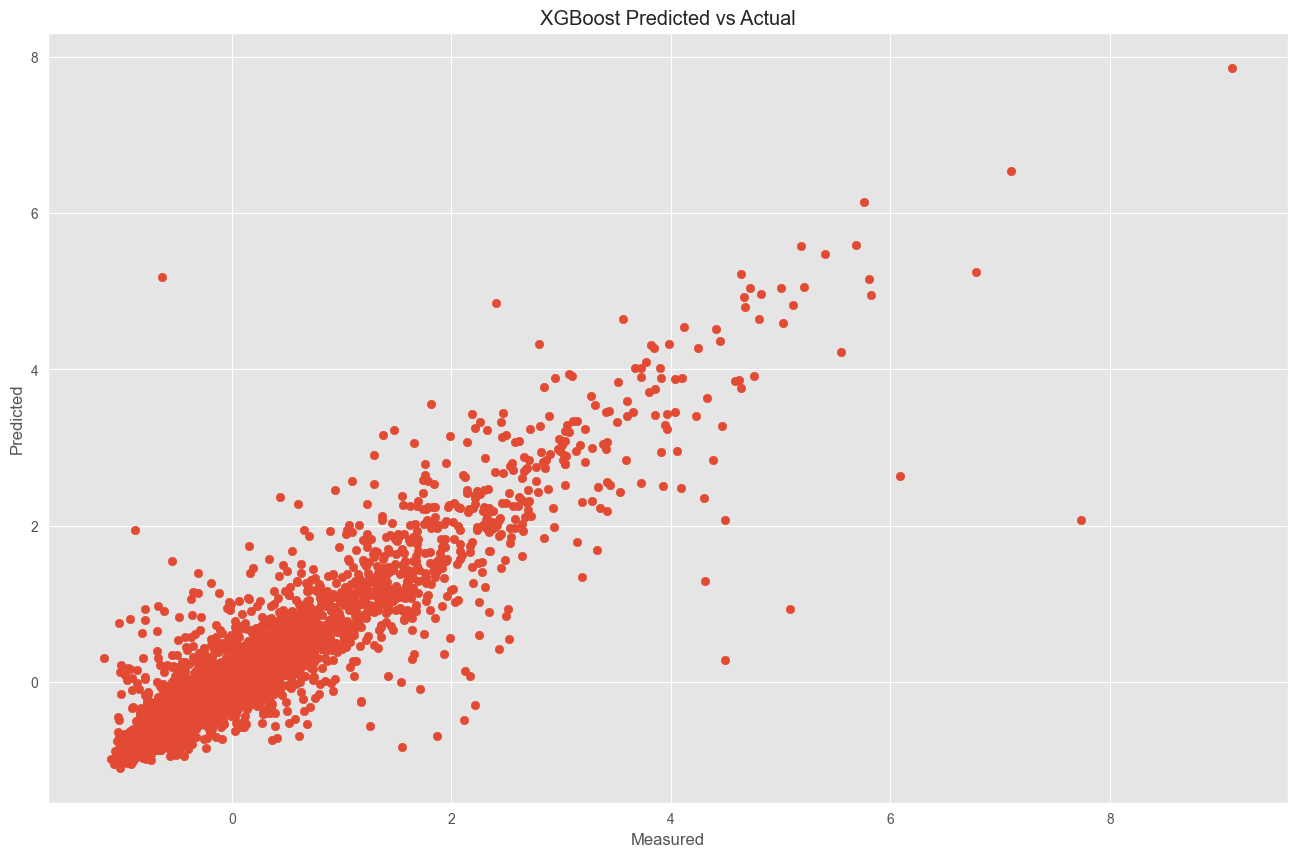

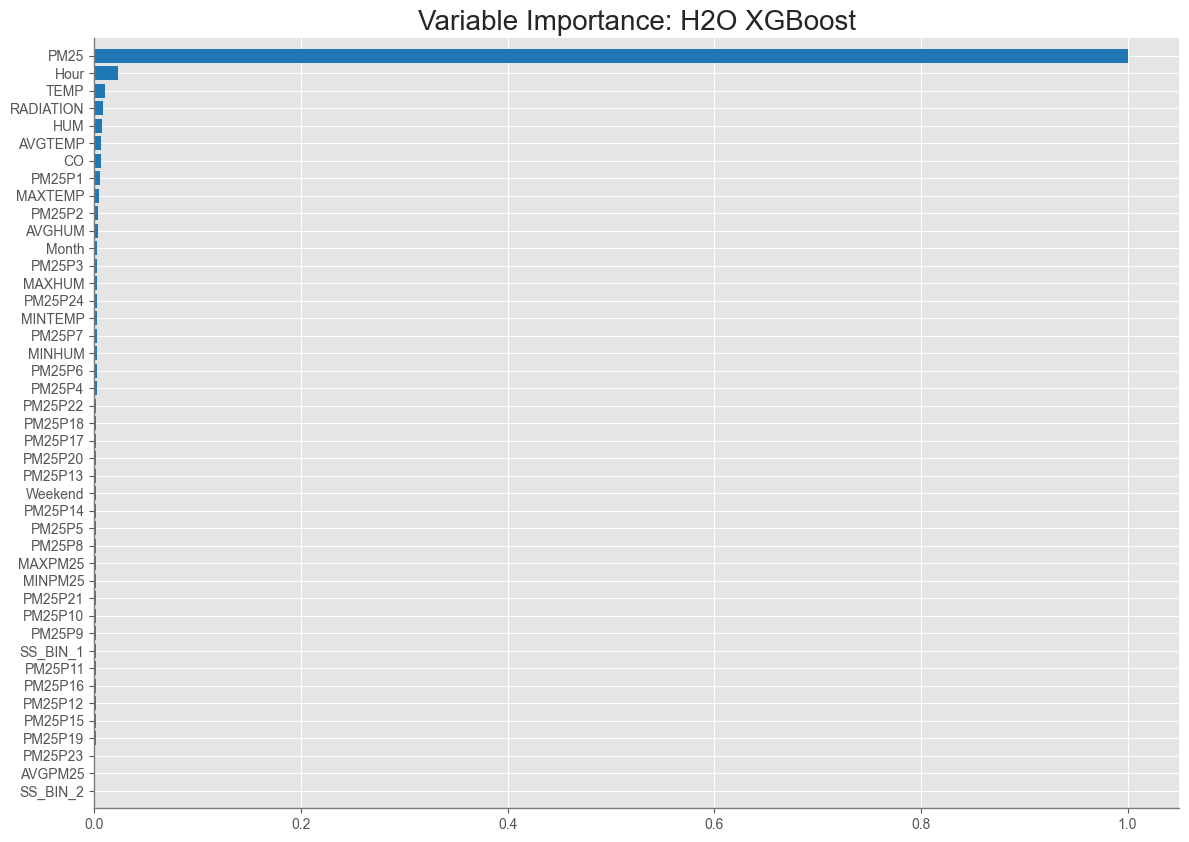

<Figure size 1600x1000 with 0 Axes>

In [16]:
perf = xgb.model_performance(valid=True)
print(perf)
print(f"R-squared: {xgb.r2(valid=True)}")
print(f"Training time: {(end_time - start_time) / 10 ** 6} ms")

# Generate predictions on a test set (if necessary):
pred = xgb.predict(valid)
pred = h2o.as_list(pred).values.tolist()
actual_vals = valid[-1].as_data_frame().values.tolist()

plt.scatter(actual_vals, pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('XGBoost Predicted vs Actual')
plt.show()

xgb.varimp_plot(num_of_features=100)

## Call to the H2O server to train a MLP model

In [ ]:
dl = H2ODeepLearningEstimator(hidden=[128, 64, 32],
                              mini_batch_size=256,
                              epochs=1000,
                              train_samples_per_iteration=-1,
                              reproducible=True,
                              activation="Tanh",
                              single_node_mode=False,
                              balance_classes=False,
                              force_load_balance=False,
                              adaptive_rate=False,
                              nesterov_accelerated_gradient=True,
                              momentum_start=0.05,
                              seed=23123,
                              tweedie_power=1.5,
                              score_training_samples=0,
                              score_validation_samples=0,
                              stopping_rounds=0)
start_time = time.time_ns()
dl.train(x=predictors, y=response, training_frame=train, validation_frame=valid)
end_time = time.time_ns()

deeplearning Model Build progress: |██████████████

## Evaluate the model performance and display the correlation between actual values and predicted values

In [ ]:
perf = dl.model_performance(valid=True)
print(perf)
print(f"R-squared: {dl.r2(valid=True)}")
print(f"Training time: {(end_time - start_time) / 10 ** 6} ms")

pred = dl.predict(valid)
pred = h2o.as_list(pred).values.tolist()

plt.scatter(actual_vals, pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('MLP Predicted vs Actual')
plt.show()

## Call to the H2O server to train a Random Forest model

In [ ]:
drf = H2ORandomForestEstimator(ntrees=192, max_depth=16, seed=1234)
start_time = time.time_ns()
drf.train(x=predictors, y=response, training_frame=train, validation_frame=valid)
end_time = time.time_ns()

## Evaluate the model performance and display the correlation between actual values and predicted values

In [ ]:
perf = drf.model_performance(valid=True)
print(perf)
print(f"R-squared: {drf.r2(valid=True)}")
print(f"Training time: {(end_time - start_time) / 10 ** 6} ms")

pred = drf.predict(valid)
pred = h2o.as_list(pred).values.tolist()

plt.scatter(actual_vals, pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Random Forest Predicted vs Actual')
plt.show()

drf.varimp_plot(num_of_features=100)
